<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab6.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 6: Sequence-to-sequence models

### Description:
For this lab, you will code up the [char-rnn model of Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). This is a recurrent neural network that is trained probabilistically on sequences of characters, and that can then be used to sample new sequences that are like the original.

This lab will help you develop several new skills, as well as understand some best practices needed for building large models. In addition, we'll be able to create networks that generate neat text!

### Deliverable:
- Fill in the code for the RNN (using PyTorch's built-in GRU).
- Fill in the training loop
- Fill in the evaluation loop. In this loop, rather than using a validation set, you will sample text from the RNN.
- Implement your own GRU cell.
- Train your RNN on a new domain of text (Star Wars, political speeches, etc. - have fun!)

### Grading Standards:
- 20% Implementation the RNN
- 20% Implementation training loop
- 20% Implementation of evaluation loop
- 20% Implementation of your own GRU cell
- 20% Training of your RNN on a domain of your choice

### Tips:
- Read through all the helper functions, run them, and make sure you understand what they are doing
- At each stage, ask yourself: What should the dimensions of this tensor be? Should its data type be float or int? (int is called `long` in PyTorch)
- Don't apply a softmax inside the RNN if you are using an nn.CrossEntropyLoss (this module already applies a softmax to its input).

### Example Output:
An example of my final samples are shown below (more detail in the
final section of this writeup), after 150 passes through the data.
Please generate about 15 samples for each dataset.

<code>
And ifte thin forgision forward thene over up to a fear not your
And freitions, which is great God. Behold these are the loss sub
And ache with the Lord hath bloes, which was done to the holy Gr
And appeicis arm vinimonahites strong in name, to doth piseling 
And miniquithers these words, he commanded order not; neither sa
And min for many would happine even to the earth, to said unto m
And mie first be traditions? Behold, you, because it was a sound
And from tike ended the Lamanites had administered, and I say bi
</code>


---

## Part 0: Readings, data loading, and high level training

---

There is a tutorial here that will help build out scaffolding code, and get an understanding of using sequences in pytorch.

* Read the following

> * [Pytorch sequence-to-sequence tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) (You will be implementing the decoder, not the encoder, as we are not doing sequence-to-sequence translation.)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)






In [16]:
! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
! tar -xzf text_files.tar.gz
! pip install unidecode
! pip install torch

import unidecode
import string
import random
import re
 
import pdb

import pandas as pd
 
all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('./text_files/lotr.txt').read())

file_len = len(file)

my_file = pd.read_csv('./text_files/avatar.csv', encoding='latin1')
my_file = my_file.loc[:, 'character_words']

my_file_text = str()
for i in range(len(my_file)):
  datum = my_file[i]

  if datum != 'NA' and type(datum) is not float:
    for c in datum:
      if c in all_characters:
        my_file_text += c
    
    my_file_text += '\n'

my_file_len = len(my_file_text)

--2023-02-18 22:53:30--  https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz
Resolving piazza.com (piazza.com)... 18.235.185.127, 52.205.194.150, 18.215.222.38, ...
Connecting to piazza.com (piazza.com)|18.235.185.127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-uploads.piazza.com/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz [following]
--2023-02-18 22:53:31--  https://cdn-uploads.piazza.com/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz
Resolving cdn-uploads.piazza.com (cdn-uploads.piazza.com)... 108.156.60.45, 108.156.60.68, 108.156.60.61, ...
Connecting to cdn-uploads.piazza.com (cdn-uploads.piazza.com)|108.156.60.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1533290 (1.5M) [application/x-gzip]
Saving to: ‘./text_files.tar.gz’

./text_files.tar.gz 100%[===================>]   1.46M  --.-K

In [17]:
def random_chunk(fl, fl_len, chunk_len):
  start_index = random.randint(0, fl_len - chunk_len)
  end_index = start_index + chunk_len + 1
   
  return fl[start_index:end_index]

In [18]:
import torch

# Turn string into list of longs
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
    tensor[c] = all_characters.index(string[c])
  
  return tensor

---

## Part 4: Creating your own GRU cell 

**(Come back to this later - its defined here so that the GRU will be defined before it is used)**

---

The cell that you used in Part 1 was a pre-defined Pytorch layer. Now, write your own GRU class using the same parameters as the built-in Pytorch class does.

Please do not look at the documentation's code for the GRU cell definition. The answer is right there in the code, and in theory, you could just cut-and-paste it. This bit is on your honor!

**TODO:**
* Create a custom GRU cell

**DONE:**



In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(GRU, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()

    self.mods = nn.ModuleDict() # nn.ModuleList()
    for i in range(1, num_layers + 1):
      module_ir = nn.Linear(input_size, hidden_size, bias=True)
      module_hr = nn.Linear(hidden_size, hidden_size, bias=True)
      module_iz = nn.Linear(input_size, hidden_size, bias=True)
      module_hz = nn.Linear(hidden_size, hidden_size, bias=True)
      module_in = nn.Linear(input_size, hidden_size, bias=True)
      module_hn = nn.Linear(hidden_size, hidden_size, bias=True)
      
      self.mods['ir:' + str(i)] = module_ir
      self.mods['hr:' + str(i)] = module_hr
      self.mods['iz:' + str(i)] = module_iz
      self.mods['hz:' + str(i)] = module_hz
      self.mods['in:' + str(i)] = module_in
      self.mods['hn:' + str(i)] = module_hn

  def forward(self, inputs, hidden):
    # Each layer does the following:
    hiddens = []
    for i in range(1, self.num_layers + 1):
      r_t = self.sigmoid(self.mods['ir:' + str(i)](inputs) + self.mods['hr:' + str(i)](hidden[i - 1])) # num_layer x 1 x hidden_size
      z_t = self.sigmoid(self.mods['iz:' + str(i)](inputs) + self.mods['hz:' + str(i)](hidden[i - 1]))
      n_t = self.tanh(self.mods['in:' + str(i)](inputs) + torch.mul(r_t, self.mods['hn:' + str(i)](hidden[i - 1])))

      inputs = torch.mul( torch.ones_like(z_t) - z_t, n_t) + torch.mul(z_t, hidden[i - 1])
      
      hiddens.append(hidden[i - 1])
    
    hiddens = torch.stack(hiddens)
    outputs = inputs

    return outputs, hiddens
  


---

##  Part 1: Building a sequence to sequence model

---

Great! We have the data in a useable form. We can switch out which text file we are reading from, and trying to simulate.

We now want to build out an RNN model, in this section, we will use all built in Pytorch pieces when building our RNN class.


**TODO:**
* Create an RNN class that extends from nn.Module.

**DONE:**



In [20]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1, my_GRU=False):
    super(RNN, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    
    self.embedding = nn.Embedding(input_size, hidden_size)

    if not my_GRU:
      self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
    else:
      self.gru = GRU(hidden_size, hidden_size, n_layers) # user defined GRU
    
    self.out = nn.Linear(hidden_size, output_size)

  def forward(self, input_char, hidden):
    # by reviewing the documentation, construct a forward function that properly
    # uses the output of the GRU

    output = self.embedding(input_char).view(1, 1, -1)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    out_decoded = self.out(output)
    
    return out_decoded, hidden

  def init_hidden(self):
    return torch.zeros(self.n_layers, 1, self.hidden_size, device='cpu')

In [21]:
def random_training_set(fl, fl_len, chunk_len):    
  chunk = random_chunk(fl, fl_len, chunk_len)
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  
  return inp, target

---

## Part 2: Sample text and Training information

---

We now want to be able to train our network, and sample text after training.

This function outlines how training a sequence style network goes. 

**TODO:**
* Fill in the pieces.

**DONE:**




In [22]:
# NOTE: decoder_optimizer, decoder, and criterion will be defined below as global variables
def train(inp, target, decoder, optimizer):
  hidden = decoder.init_hidden()
  optimizer.zero_grad()

  target_length = target.size(0)

  loss = 0
  
  for di in range(target_length):
    output, hidden = decoder(inp[di], hidden)
    
    loss += criterion(torch.squeeze(output, 0), torch.unsqueeze(target[di], 0)) 

  loss.backward()
  optimizer.step()

  return loss.item() / target_length

---

## Part 3: Sample text and Training information

---

You can at this time, if you choose, also write out your train loop boilerplate that samples random sequences and trains your RNN. This will be helpful to have working before writing your own GRU class.

If you are finished training, or during training, and you want to sample from the network you may consider using the following function. If your RNN model is instantiated as `decoder`then this will probabilistically sample a sequence of length `predict_len`

**TODO:**
* Fill out the evaluate function to generate text frome a primed string

**DONE:**



In [23]:
def sample_outputs(output, temperature):
    """Takes in a vector of unnormalized probability weights and samples a character from the distribution"""
    # As temperature approaches 0, this sampling function becomes argmax (no randomness)
    # As temperature approaches infinity, this sampling function becomes a purely random choice
    return torch.multinomial(torch.exp(output / temperature), 1)

def evaluate(decoder, prime_str='A', predict_len=100, temperature=0.8): # produce new sentence
  ## initialize hidden state, initialize other useful variables
  hidden = decoder.init_hidden()
  output_str = str(prime_str)
  prime_char_tensor = char_tensor(output_str)

  _, hidden = decoder(prime_char_tensor[0], hidden)

  while len(output_str) <= predict_len:
    input_char_tensor = char_tensor(output_str)
    output, hidden = decoder(input_char_tensor[-1], hidden) # dist of characters
    
    index = sample_outputs(torch.squeeze(output, 0), temperature) # index of likely char
    char = all_characters[index]

    output_str += char # buid output string
  
  return output_str
  

---

## Part 4: (Create a GRU cell, requirements above)

---



---

## Part 5: Run it and generate some text!

---


**TODO:** 
* Create some cool output

**DONE:**




Assuming everything has gone well, you should be able to run the main function in the scaffold code, using either your custom GRU cell or the built in layer, and see output something like this. I trained on the “lotr.txt” dataset, using chunk_length=200, hidden_size=100 for 2000 epochs. These are the results, along with the prime string:

---

 G:
 
 Gandalf was decrond. 
'All have lord you. Forward the road at least walk this is stuff, and 
went to the long grey housel-winding and kindled side was a sleep pleasuring, I do long 
row hrough. In  

 lo:
 
 lost death it. 
'The last of the gatherings and take you,' said Aragorn, shining out of the Gate. 
'Yes, as you there were remembaused to seen their pass, when? What 
said here, such seven an the sear 

 lo:
 
 low, and frod to keepn 
Came of their most. But here priced doubtless to an Sam up is 
masters; he left hor as they are looked. And he could now the long to stout in the right fro horseless of 
the like 

 I:
 
 I had been the 
in his eyes with the perushed to lest, if then only the ring and the legended 
of the less of the long they which as the 
enders of Orcovered and smood, and the p 

 I:
 
 I they were not the lord of the hoomes. 
Home already well from the Elves. And he sat strength, and we 
housed out of the good of the days to the mountains from his perith. 

'Yess! Where though as if  

 Th:
 
 There yarden 
you would guard the hoor might. Far and then may was 
croties, too began to see the drumbred many line 
and was then hoard walk and they heart, and the chair of the 
Ents of way, might was 

 G:
 
 Gandalf 
been lat of less the round of the stump; both and seemed to the trees and perished they 
lay are speered the less; and the wind the steep and have to she 
precious. There was in the oonly went 

 wh:
 
 which went out of the door. 
Hull the King and of the The days of his brodo 
stumbler of the windard was a thing there, then it been shining langing 
to him poor land. They hands; though they seemed ou 

 ra:
 
 rather,' have all the least deather 
down of the truven beginning to the house of sunk. 
'Nark shorts of the Eyes of the Gate your great nothing as Eret. 
'I wander trust horn, and there were not, it  

 I:
 
 I can have no mind 
together! Where don't may had one may little blung 
terrible to tales. And turn and Gandalf shall be not to as only the Cattring 
not stopped great the out them forms. On they she lo 

---


In [26]:
import time

print_every = 50
plot_every = 10
hidden_size = 200
n_layers = 3
lr = 0.001
 
decoder = RNN(n_characters, hidden_size, n_characters, n_layers, my_GRU=True) # user defined GRU
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
 
start = time.time()
all_losses = []
loss_avg = 0

In [27]:
n_epochs = 2000
for epoch in range(1, n_epochs + 1):
  loss_ = train(*random_training_set(file, file_len, 200), decoder, decoder_optimizer)
  loss_avg += loss_

  if epoch % print_every == 0:
      print('[%.3s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
      print(evaluate(decoder, 'Wh', 100), '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

[29. (50 2%) 3.0866]
Wh uD e hlgmadno  tteklahe gt aywsesea yceenitar tshhi gei  v  .'a lre tafgntaelbeewh
baorseon
 h ind 

[57. (100 5%) 2.8205]
Whe iusan teor nsare t pcirshos :oy t thi w s at 
hen I as nndr ly s fhhn, be 
hey aree, as thr w tew 

[85. (150 7%) 2.6988]
Whe 
t Ed aud mere 
)de winre th ns 
puon t win ciut lhant 
tse s 're t.han we pthe anr 
the a om s y 

[112 (200 10%) 2.5405]
Wheseda hee idos w se 
ther poonive uloninde theded or Go rsweg,r t and aoy 

d theme se nvhee fe 

a 

[140 (250 12%) 2.4567]
Wher he or Ze at s l s and 


aomer oran s te 
qed sand 
f 
wer nts ad tofo af atore g. aves t 
ts se 

[168 (300 15%) 2.4062]
Whe 'rkeong he as 
be fee cesanee nd mes sofon h fe 
Bkerasond touneasare wen as t t r. weorernd ward 

[197 (350 17%) 2.4806]
Whyitoredas anan 
'la. 
wre ano st warer t te 
s on t hefr sastokowin, n wirady l k I Lhe ise thill 
 

[224 (400 20%) 2.3364]
Whe s, Leing  to 

thesoutourn ame se d S
n win antheshere he ware nstheld 

aing sthe s gat

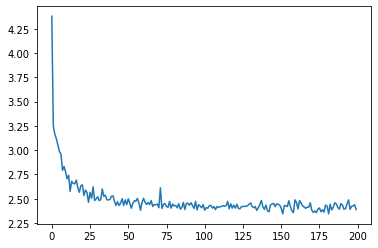

In [34]:
plt.plot(all_losses)
plt.show()

In [28]:
for i in range(10): # Evaluation using user defined GRU
  start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])

  print(evaluate(decoder, start_strings[start], 200), '\n')

 he
 hee ring tt s tous wadst s han bofend ond or thawoo 


m t 

y 

Bund, ieljume st se Bolo o sly ' at is thanathers. ' as t Ithe I hin th th 
y 
hat d t ot s y mase tw ind. e t 

un hitpl thirardoud le 

 Th
 Thourtest they igot sus sthay t bere Fr. noton t f tund h on was ged he wer s wang y tho 
The. 
t a t 
hen t eme as in the t amure minghe m w y He oly then f wod mendin athe y s yhere t ns n. th 
st t 

 ra
 rar. te Lo wousad n! hes ssat y s the s, 
terousa mon an d an the nd tre Souge t r a w s mino tondat Bun t ton wack 

pee sed ay baimowake de y 
rd 

Than watir ong 
Bad 
wiem llimar at 

' she se I a 

 G
 Gon then by towim leen him d I hin Gas I o o wie t telsso the 
Bove 

Go chesangld omickito t t anco f to 
r Sarorn I hindorepllle. dsng as the onator 



Mowenoulde in islly read as the s sthad sst l 

 ca
 cas wa s ly t as thinowhees sore ar 
Merind beralomoo s se s lser he stheteake che so t fo dan the ind Cainck 

Gantherere owe 

hes fe fr mar hed 
thisau h, hadoun

---

## Part 6: Generate output on a different dataset

---

**TODO:**

* Choose a textual dataset. Here are some [text datasets](https://www.kaggle.com/datasets?tags=14104-text+data%2C13205-text+mining) from Kaggle 

* Generate some decent looking results and evaluate your model's performance (say what it did well / not so well)

**DONE:**



In [29]:
my_decoder = RNN(n_characters, hidden_size, n_characters, 5, my_GRU=True) # user defined GRU
my_decoder_optimizer = torch.optim.Adam(my_decoder.parameters(), lr=lr)
 
start = time.time()
my_all_losses = []
my_loss_avg = 0

n_epochs = 2000
for epoch in range(1, n_epochs + 1):
  loss_ = train(*random_training_set(my_file_text, my_file_len, 200), my_decoder, my_decoder_optimizer)       
  my_loss_avg += loss_

  if epoch % print_every == 0:
      print('[%.3s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
      print(evaluate(my_decoder, 'Wh', 100), '\n')

  if epoch % plot_every == 0:
      my_all_losses.append(my_loss_avg / plot_every)
      my_loss_avg = 0

[46. (50 2%) 3.2379]
Wh e,erreodAuta at.   r  u nsftawyl niYuhyeeo mYamnosaaWgonlneDn hnIoIs  er htkuaat etwearnAoSno ntop 

[94. (100 5%) 3.2782]
Whs Lt
.eeed euufaer
einruphrr
leao eeti .h pkuKs e ma
Shoeata thn t uG t etr e ? leolko ae dti
ue g  

[141 (150 7%) 3.0779]
WhDoeoi r hu ieefhe numa .ea'N d g.u   lWrtuvSduu tudoeasshyeg es e cee uhnhhtl rdanIn .  e?lhflph ea 

[188 (200 10%) 3.1563]
WhonI as s n . tsoYkfa  rat hee de oao gksane f
 Weeh  s hb  s iedaun  ttIin e pkTgtro orA   ee n ta  

[235 (250 12%) 3.1025]
Wh thoesgiaoi  te
tIen  .v     acawrts .fy.tm e ,Ie
iouweu ., Iuu  iwnenll ea  ea to hmh en.ewIrI odr 

[282 (300 15%) 3.1407]
Wh    ditaeegvt yl jtspstituno    utui elot s 
 igldaf  ouo od  gortorn h.otee.d sTnone eoetlnmdrhibn 

[329 (350 17%) 2.9428]
Wh ce tatit ye seootlun
ty lo kee c I t at A t "e aonmnaeorynos tn tngotouasot t mo tee m t I cuk fre 

[377 (400 20%) 2.8336]
Whe y tokorota, f h 
wnre yogen st t Isorov tiag bedek s s Aas g
yov te t nnison t d aset ad

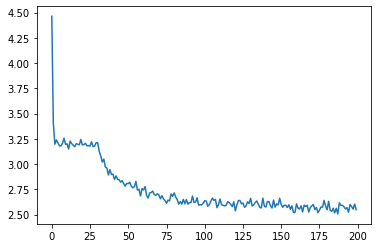

In [33]:
plt.plot(my_all_losses)
plt.show()

In [30]:
for i in range(10):
  start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])

  print(evaluate(my_decoder, start_strings[start], 200), '\n')

 Th
 Thoue!
Kofote Werou as Denofo, bar wem c ber.
Nou thbestaf t  o thir t Asevetak Yhe so wh. cabean. Anoki!
Elernd Aley ger wourr, werire,om o an pe tou. m.
Nal s ..
Perir s peng m whe adomn'nd Fed toen 

 Th
 Thoorend Buwe wo!
Id s me'sou jngathe n's we thame g  hele whe rite on'iry tangltle en ou g theld y u Ar you hedtopoure t so ano y r d dbe an?
Tarele hsour acour wure o tet.  the t w Ye!
Alive s be so 

 G
 Gayo che f thar fowave te'ld he wenghe Me be'sou's hokd!
I'serer Thirl wonds ourinrou bis be s c!
I lund heser cu sut theerperou  ber to t g'mor Fereerouay ewor T you thebouthe thed'tave He an'sor t t 

 Th
 They wangou tttes ba't  Iro af ouamd thi ipo owon's .
Is,e Wher tr, lo Fantirrtou Wthe Shavas coureroun...
Were f Sor Fati his 's d f i bathe be's wiy wer,othome tou tt acas  war aree s taco  teacou   

 I 
 I wo fin t tou visoou o yong ter ber the wo wesou o yo ou Dhoran malaree hpor l tr of o d basour Thoumevete w Fand a a'thar wson me p.
Wh?   he spouy m heof teyire 